# ClimateNet AR Analysis: ARTMIP comparisons

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import xesmf as xe
import nc_time_axis
import cftime 
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import matplotlib.colors as mcolors
import matplotlib as mpl

In [2]:
# Import dask
import dask

# Use dask jobqueue
from dask_jobqueue import PBSCluster

# Import a client
from dask.distributed import Client

# Setup your PBSCluster
# 5 GB was fine for western US but ran into memory issues for western Europe...due to extra rolling step to fix lons?
nmem1 = '20GiB' # PBSCluster specification
nmem2 = '20GB' # pbs specification
cluster = PBSCluster(
    cores=1, # The number of cores you want
    memory=nmem1, # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='/glade/derecho/scratch/kdagon/dask-local', # Use your local directory
    resource_spec='select=1:ncpus=1:mem='+nmem2, # Specify resources
    account='P06010014', # Input your project ID here
    walltime='03:00:00', # Amount of wall time
    interface='ext', # Interface to use
)

# Scale up -- how to determine this number?
cluster.scale(10)

# Change your url to the dask dashboard so you can see it
#dask.config.set({'distributed.dashboard.link':'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'})

# Setup your client
client = Client(cluster)

/glade/work/kdagon/conda-envs/PEx_v2/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 43717 instead
  warnings.warn(


In [3]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kdagon/proxy/43717/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kdagon/proxy/43717/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://128.117.208.95:44563,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kdagon/proxy/43717/status,Total threads: 0
Started: Just now,Total memory: 0 B


## Set ClimateNet filepath

In [4]:
cesm_cnet_filepath = "/glade/campaign/cgd/ccr/kdagon/cgnet/" # retrained NCAR model, after data processing workflow was finalized

## Set regional bounds

In [5]:
# Selected transects along the North American West Coast (Rutz et al. 2019)
lat_bounds = slice(32,55)
lon_bounds = slice(230,255)

# Western Europe
#lat_bounds = slice(35,62) # Might even adjust down to 60N based on Fig. 4 of Rutz et al.
#lon_bounds = slice(-20,10) # Roll lons!
#lon_bounds = slice(345, 360) # visually it looks like Rutz et al. stops at 0E even though the NCL code uses 10E. In this case I wouldn't have to roll lons. Rutz et al. also mentions 15W as western boundary.

### Preprocessing function to subset regionally

In [6]:
def preprocess_region(ds):
    # return regional domain

    # rolling for western Europe slice crossing meridian
    #ds = ds.assign_coords(lon=(((ds.lon + 180) % 360) - 180))
    #ds = ds.roll(lon=int(len(ds['lon']) / 2), roll_coords=True)
    
    return ds['masks'].sel(lat=lat_bounds,lon=lon_bounds)

## Read in landfrac for this grid
To subset land points

In [7]:
landfrac_file = "/glade/campaign/cgd/ccr/kdagon/dlfront/postprocessing/USGS-gtopo30_ne120np4_16xdel2-PFC-consistentSGH.regrid_0.23x0.31.nc"
landfrac_ds = xr.open_dataset(landfrac_file)

# rolling for western Europe slice
#landfrac_ds = landfrac_ds.assign_coords(lon=(((landfrac_ds.lon + 180) % 360) - 180))
#landfrac_ds = landfrac_ds.roll(lon=int(len(landfrac_ds['lon']) / 2), roll_coords=True)

landfrac = landfrac_ds.LANDFRAC.sel(lat=lat_bounds,lon=lon_bounds)

In [8]:
landfrac

<xarray.DataArray 'LANDFRAC' (lat: 98, lon: 81)>
[7938 values with dtype=float64]
Coordinates:
  * lat      (lat) float64 32.03 32.27 32.5 32.74 ... 54.09 54.33 54.56 54.8
  * lon      (lon) float64 230.0 230.3 230.6 230.9 ... 254.1 254.4 254.7 255.0
Attributes:
    long_name:      gridbox land fraction
    cell_measures:  area: area

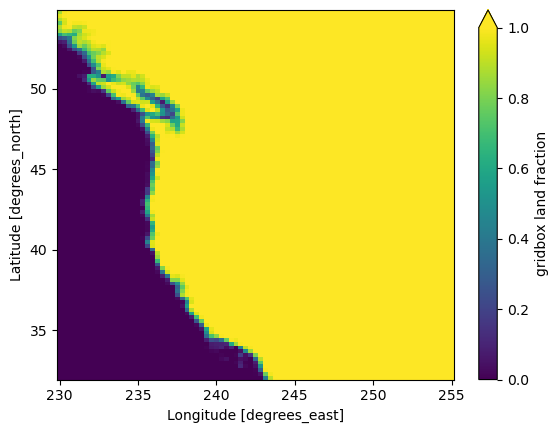

In [9]:
landfrac.plot(robust=True);

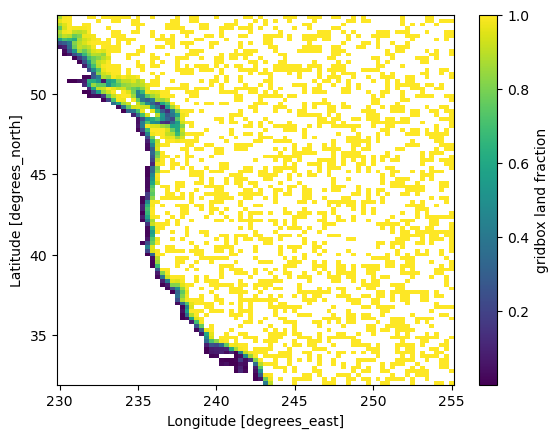

In [11]:
landfrac.where((landfrac > 0) & (landfrac < 1)).plot();

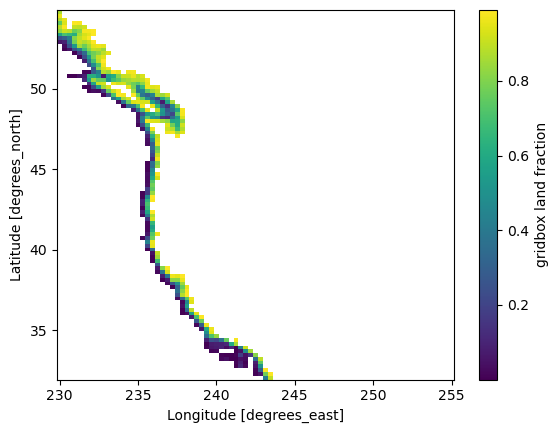

In [10]:
landfrac.where((landfrac > 0) & (landfrac < 0.99)).plot();

## CESM historical simulation

In [12]:
hist_yrs = [str(i) for i in range(2000,2006)]
hist_folders = ["B20TRC5CN/"+y+"/masks_unwgt/" for y in hist_yrs] # unweighted means/std

In [13]:
cnet_file = 'class_masks.nc' # can't use wildcard for this to work?
hist_paths = [cesm_cnet_filepath+hist_folders[i]+cnet_file for i,f in enumerate(hist_folders)]
#hist_paths

### Read in masks with preprocessing

In [14]:
%%time
cnet_hist_shift = xr.open_mfdataset(hist_paths, concat_dim='time',combine='nested', chunks={'time':500}, parallel=True, preprocess=preprocess_region)

CPU times: user 2.09 s, sys: 74.8 ms, total: 2.17 s
Wall time: 29.2 s


In [15]:
cnet_hist_shift

<xarray.DataArray 'masks' (time: 17520, lat: 98, lon: 81)>
dask.array<concatenate, shape=(17520, 98, 81), dtype=int64, chunksize=(500, 98, 81), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 230.0 230.3 230.6 230.9 ... 254.1 254.4 254.7 255.0
  * lat      (lat) float64 32.03 32.27 32.5 32.74 ... 54.09 54.33 54.56 54.8
  * time     (time) object 2000-01-01 03:00:00 ... 2006-01-01 00:00:00
Attributes: (12/21)
    CDI:                        Climate Data Interface version 2.0.2 (https:/...
    Conventions:                CF-1.0
    source:                     CAM
    history:                    Fri Feb 17 16:11:24 2023: cdo splitsel,1 2000...
    remap_script:               ncremap
    remap_command:              '/glade/u/apps/dav/opt/nco/4.7.9/gnu/8.3.0/bi...
    ...                         ...
    Version:                    $Name$
    revision_Id:                $Id$
    initial_file:               /projects/ccsm/inputdata/atm/cam/inic/homme/c...
    topography_file:            /projects/ccsm/inputdata/atm/cam/topo/USGS-gt...
    history_of_appended_files:  Fri Feb 17 15:31:33 2023: Appended file 2000_...
    CDO:                        Climate Data Operators version 2.0.1 (https:/...

In [129]:
# OPTIONAL: persist for W Euro calcs with rolling lons (why does it add so much to the dask task graph?)
#cnet_hist_shift = cnet_hist_shift.persist() # could also persist after timeshift

### Shift time indices of 2000-2005 back 3hrs to avoid duplicative index

In [17]:
timeshift = cnet_hist_shift.sel(time=slice("2000-01-01 03:00:00","2006-01-01 00:00:00")).time.indexes['time'].shift(-3,"h")
#timeshift

In [18]:
cnet_hist = cnet_hist_shift.sel(time=slice("2000-01-01 03:00:00","2006-01-01 00:00:00")).assign_coords(time=timeshift)
cnet_hist

<xarray.DataArray 'masks' (time: 17520, lat: 98, lon: 81)>
dask.array<concatenate, shape=(17520, 98, 81), dtype=int64, chunksize=(500, 98, 81), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 230.0 230.3 230.6 230.9 ... 254.1 254.4 254.7 255.0
  * lat      (lat) float64 32.03 32.27 32.5 32.74 ... 54.09 54.33 54.56 54.8
  * time     (time) object 2000-01-01 00:00:00 ... 2005-12-31 21:00:00
Attributes: (12/21)
    CDI:                        Climate Data Interface version 2.0.2 (https:/...
    Conventions:                CF-1.0
    source:                     CAM
    history:                    Fri Feb 17 16:11:24 2023: cdo splitsel,1 2000...
    remap_script:               ncremap
    remap_command:              '/glade/u/apps/dav/opt/nco/4.7.9/gnu/8.3.0/bi...
    ...                         ...
    Version:                    $Name$
    revision_Id:                $Id$
    initial_file:               /projects/ccsm/inputdata/atm/cam/inic/homme/c...
    topography_file:            /projects/ccsm/inputdata/atm/cam/topo/USGS-gt...
    history_of_appended_files:  Fri Feb 17 15:31:33 2023: Appended file 2000_...
    CDO:                        Climate Data Operators version 2.0.1 (https:/...

## CESM RCP2.6 simulation

In [19]:
rcp26_yrs = [str(i) for i in range(2006,2016)]
rcp26_folders = ["BRCP26C5CN/"+y+"/masks_unwgt/" for y in rcp26_yrs] # unweighted means/std

In [20]:
cnet_file = 'class_masks.nc' # can't use wildcard for this to work?
rcp26_paths = [cesm_cnet_filepath+rcp26_folders[i]+cnet_file for i,f in enumerate(rcp26_folders)]
#rcp26_paths

### Read in masks with preprocessing

In [21]:
%%time
cnet_rcp26 = xr.open_mfdataset(rcp26_paths, concat_dim='time',combine='nested', chunks={'time':500}, parallel=True, preprocess=preprocess_region)

CPU times: user 387 ms, sys: 29.2 ms, total: 417 ms
Wall time: 2.57 s


In [22]:
cnet_rcp26

<xarray.DataArray 'masks' (time: 29200, lat: 98, lon: 81)>
dask.array<concatenate, shape=(29200, 98, 81), dtype=int64, chunksize=(500, 98, 81), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 230.0 230.3 230.6 230.9 ... 254.1 254.4 254.7 255.0
  * lat      (lat) float64 32.03 32.27 32.5 32.74 ... 54.09 54.33 54.56 54.8
  * time     (time) object 2006-01-01 00:00:00 ... 2015-12-31 21:00:00
Attributes: (12/21)
    CDI:                        Climate Data Interface version 2.0.2 (https:/...
    Conventions:                CF-1.0
    source:                     CAM
    np:                         4
    ne:                         120
    case:                       b.e13.BRCP26C5CN.ne120_g16.003
    ...                         ...
    remap_version:              4.7.9
    NCO:                        netCDF Operators version 4.7.9 (Homepage = ht...
    map_file:                   /glade/p/cgd/amp/jet/mapfiles/map_ne120_to_dl...
    input_file:                 /glade/campaign/cgd/amp/jet/ClimateNet/data_p...
    history_of_appended_files:  Mon Apr  3 10:28:39 2023: Appended file 2006_...
    CDO:                        Climate Data Operators version 2.0.1 (https:/...

In [134]:
# OPTIONAL: persist for W Euro calcs with rolling lons (why does it add so much to the dask task graph?)
#cnet_rcp26 = cnet_rcp26.persist()

## Combine historical/RCP2.6

In [23]:
cnet_hist_rcp26 = xr.concat([cnet_hist, cnet_rcp26], dim='time')
cnet_hist_rcp26

<xarray.DataArray 'masks' (time: 46720, lat: 98, lon: 81)>
dask.array<concatenate, shape=(46720, 98, 81), dtype=int64, chunksize=(500, 98, 81), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 230.0 230.3 230.6 230.9 ... 254.1 254.4 254.7 255.0
  * lat      (lat) float64 32.03 32.27 32.5 32.74 ... 54.09 54.33 54.56 54.8
  * time     (time) object 2000-01-01 00:00:00 ... 2015-12-31 21:00:00
Attributes: (12/21)
    CDI:                        Climate Data Interface version 2.0.2 (https:/...
    Conventions:                CF-1.0
    source:                     CAM
    history:                    Fri Feb 17 16:11:24 2023: cdo splitsel,1 2000...
    remap_script:               ncremap
    remap_command:              '/glade/u/apps/dav/opt/nco/4.7.9/gnu/8.3.0/bi...
    ...                         ...
    Version:                    $Name$
    revision_Id:                $Id$
    initial_file:               /projects/ccsm/inputdata/atm/cam/inic/homme/c...
    topography_file:            /projects/ccsm/inputdata/atm/cam/topo/USGS-gt...
    history_of_appended_files:  Fri Feb 17 15:31:33 2023: Appended file 2000_...
    CDO:                        Climate Data Operators version 2.0.1 (https:/...

## Persist to make the following calcs faster
If not already done above

In [24]:
cnet_hist_rcp26 = cnet_hist_rcp26.persist()

## Define ARs

In [25]:
AR = cnet_hist_rcp26.clip(min=1)-1
AR

<xarray.DataArray 'masks' (time: 46720, lat: 98, lon: 81)>
dask.array<sub, shape=(46720, 98, 81), dtype=int64, chunksize=(500, 98, 81), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 230.0 230.3 230.6 230.9 ... 254.1 254.4 254.7 255.0
  * lat      (lat) float64 32.03 32.27 32.5 32.74 ... 54.09 54.33 54.56 54.8
  * time     (time) object 2000-01-01 00:00:00 ... 2015-12-31 21:00:00

## Counts at coastline
Using `artmip_countsbylat_xy.env.ncl` and `plot_artmip_countsbylat_newmethod_xy.ncl` from C. Shields as a starting point

### ARcount over time at each gridpoint

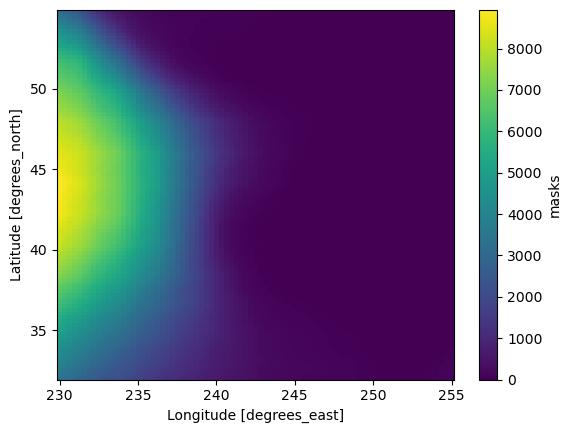

In [26]:
ARcount = AR.sum(dim='time')
ARcount.plot();

### Select for fractional land/sea points

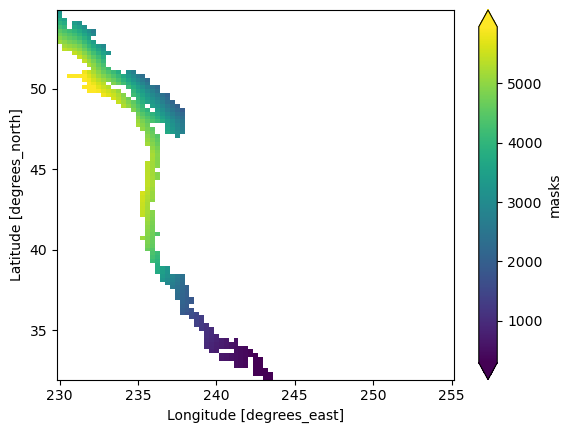

In [27]:
#ARcount_frac = ARcount.where((landfrac > 0) & (landfrac < 1)) 
ARcount_frac = ARcount.where((landfrac > 0) & (landfrac < 0.99)) # upper bound chosen to account for weird behavior in landfrac max when using upper bound < 1
ARcount_frac.plot(robust=True);

In [34]:
ARcount_frac

<xarray.DataArray 'masks' (lat: 98, lon: 81)>
dask.array<where, shape=(98, 81), dtype=float64, chunksize=(98, 81), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 230.0 230.3 230.6 230.9 ... 254.1 254.4 254.7 255.0
  * lat      (lat) float64 32.03 32.27 32.5 32.74 ... 54.09 54.33 54.56 54.8

### Debugging - check individual plots

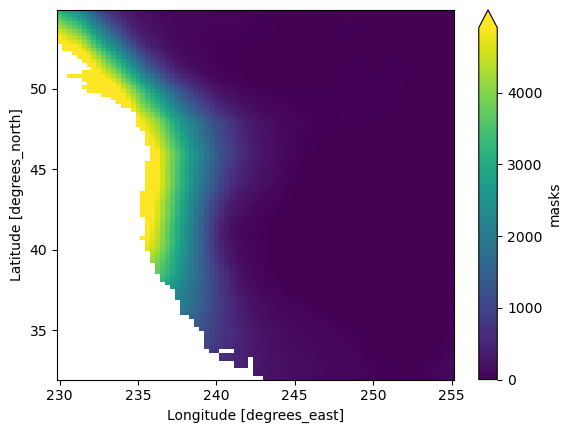

In [49]:
ARcount.where(landfrac > 0).plot(robust=True);

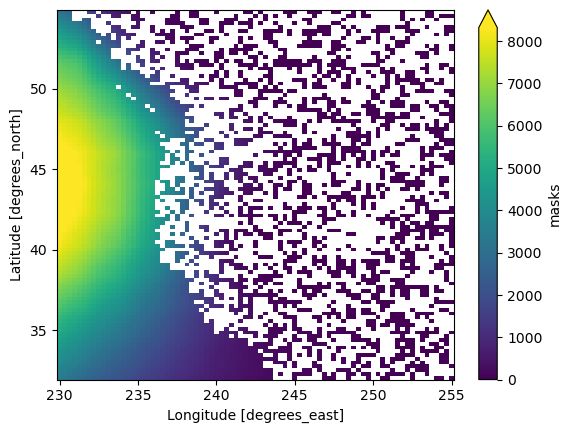

In [50]:
ARcount.where(landfrac < 1).plot(robust=True);

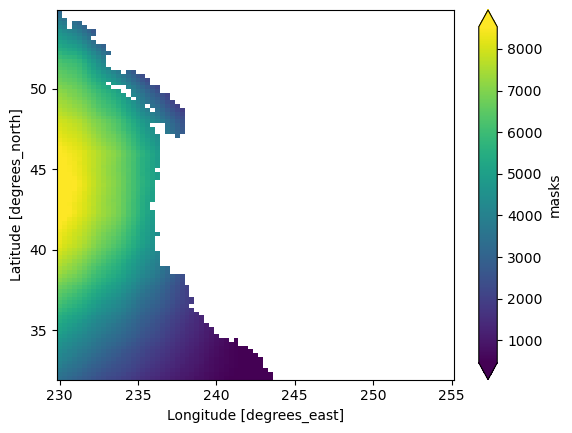

In [51]:
# it's a weird rounding thing!! something with interpreting landfrac
ARcount.where(landfrac < 0.99).plot(robust=True);

### Average(?) across longitudes at each latitude
Would we want sum / total time points for frequency?\
There aren't that many longitudes included though once you select for fractional land/sea points

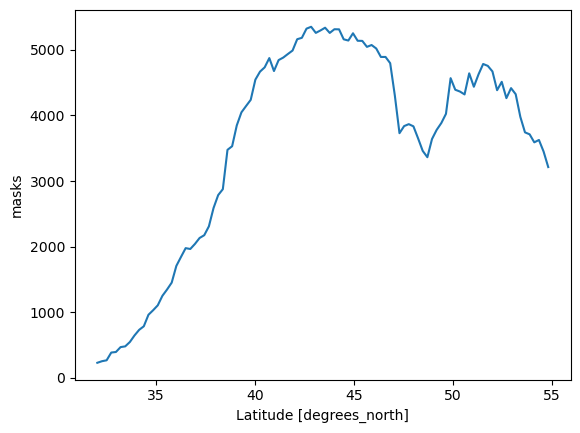

In [28]:
ARcount_frac_zmean = ARcount_frac.mean(dim='lon', skipna=True)
ARcount_frac_zmean.plot();

### Frequency calculation

Text(0.5, 1.0, 'Counts at Coastlines, CESM Historical (2000-2015)\nWestern North America')

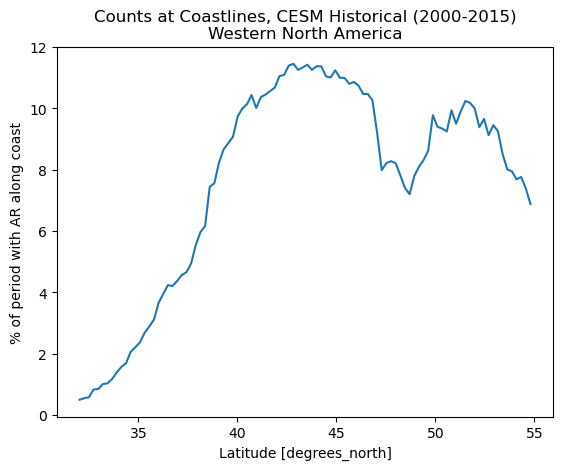

In [29]:
ARfreq_frac_zmean = 100*(ARcount_frac_zmean / len(AR.time))
ARfreq_frac_zmean.plot();
plt.ylabel('% of period with AR along coast')

plt.title('Counts at Coastlines, CESM Historical (2000-2015)\nWestern North America')
#plt.savefig('../figures/toSCP/ARfreq_frac_zmean_WUS_CESM_hist_rcp26.png');

#plt.title('Counts at Coastlines, CESM Historical (2000-2015)\nWestern Europe')
#plt.savefig('../figures/toSCP/ARfreq_frac_zmean_WEuro_CESM_hist_rcp26.png');

### Testing - try the total at each latitude instead of the average

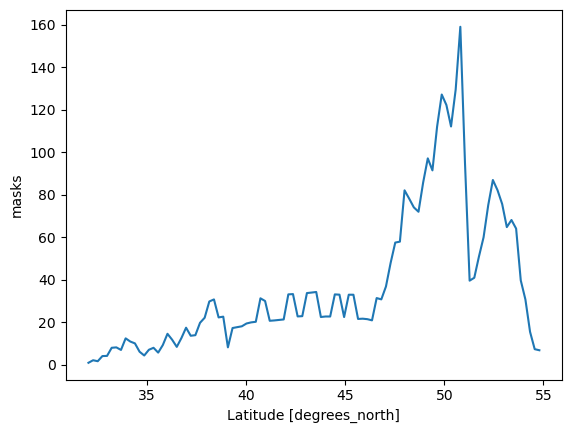

In [24]:
(100 * (ARcount_frac.sum(dim='lon', skipna=True) / len(AR.time))).plot();

## Storm Duration
Using `artmip_stormdur_countsbylat_env.ncl` and `plot_artmip_countsbylat_dur.ncl`.

It looks like the ncl code relies on an external function(?) that I don't know how to parse:\
`external ar_stormcount_artmip "/fs/cgd/home0/shields/csm/ncl/wrappers/lib/ar_stormcount_artmip.so"`

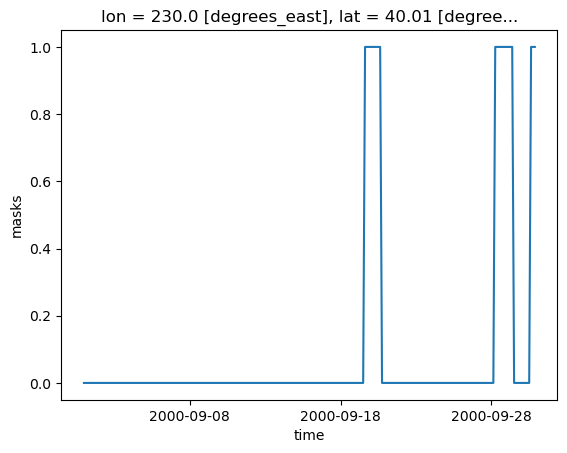

In [30]:
test_slice = AR.sel(lat=40, lon=230, method='nearest').sel(time=slice('2000-09-01','2000-09-30'))
test_slice.plot();

In [31]:
# I think what I need to do is look for consecutive 1's at each gridpoint over some time period
# Rutz et al. uses >= 12 hrs for AR event so that would be at least 5 consecutive 1's?
# Then keep track of the duration of those events so count the total # of 1's greater than or equal to 5 in a row
test_slice.values

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1])

In [32]:
# this is resampling to 12 hour periods and summing over those values
test_slice.resample(time='12h').sum().values

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 2, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 4, 4, 0, 0, 3])

In [33]:
# this is looking at rolling 5-time point periods and summing them
# so once you get a "5" that means there has been an event
# and consecutive 5's tells you something about the event duration
# for example 5 consecutive 5's represents a 24-hr event, and 6 represents a 27-hr event
test_slice.rolling(time=5).sum().values

array([nan, nan, nan, nan,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  1.,  2.,  3.,  4.,  5.,  5.,  5.,
        5.,  5.,  4.,  3.,  2.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0

## TO DO:
- think about how to compare CGNet results to ARTMIP in visuals (or by refs) - note ARTMIP plots use MERRA data for detectors
- try out duration and month of max frequency plots to also compare with ARTMIP
- CGNet run through MERRA fields to compare ML detected climate model vs. reanalysis in historical period

In [ ]:
client.close()
cluster.close()